## Circuits and Devices
This notebook has the details on how to create the circuits and devices to be executed on the Quantum Devices. The devices objects will validate the operations added to the circuits and will ensure that there are no illegal operations added to the progam, which may result in an exception when the program is executed on the Quantum Computer

In [3]:
## This is an example on the Foxtail device.
import cirq

q0 = cirq.GridQubit(0, 0)
q1 = cirq.GridQubit(0, 1)
q2 = cirq.GridQubit(0, 2)
adjacent_op = cirq.CZ(q0, q1)
nonadjacent_op = cirq.CZ(q0, q2)

# This is an unconstrained circuit with no device
free_circuit = cirq.Circuit()
# Both operations are allowed:
free_circuit.append(adjacent_op)
free_circuit.append(nonadjacent_op)
print('Unconstrained device:')
print(free_circuit)
print()

# This is a circuit on the Foxtail device
# only adjacent operations are allowed.
print('Foxtail device:')
foxtail_circuit = cirq.Circuit(device=cirq.google.Foxtail)
foxtail_circuit.append(adjacent_op)
try:
  # Not allowed, will throw exception
  foxtail_circuit.append(nonadjacent_op)
except ValueError as e:
  print('Not allowed. %s' % e)

Unconstrained device:
(0, 0): ───@───@───
           │   │
(0, 1): ───@───┼───
               │
(0, 2): ───────@───

Foxtail device:
Not allowed. Non-local interaction: cirq.CZ(cirq.GridQubit(0, 0), cirq.GridQubit(0, 2)).


## Simulation 
Let's try to simulate the two qubit Bell State by creating a circuit and then calling the simulator

In [7]:
bell_circuit = cirq.Circuit()
q0, q1 = cirq.LineQubit.range(2)
bell_circuit.append(cirq.H(q0))
bell_circuit.append(cirq.CNOT(q0, q1))

#initialize simulator
s=cirq.Simulator()

print('Simulate the Circuit:')
results=s.simulate(bell_circuit)
print(results)

#for sampling we need to add a measurement at the end
bell_circuit.append(cirq.measure(q0, q1, key='result'))

print(bell_circuit)

print('Sample the circuit:')
samples=s.run(bell_circuit, repetitions=1000)
# Print a histogram of results
print(samples.histogram(key='result'))

Simulate the Circuit:
measurements: (no measurements)
output vector: 0.707|00⟩ + 0.707|11⟩
0: ───H───@───M('result')───
          │   │
1: ───────X───M─────────────
Sample the circuit:
Counter({0: 519, 3: 481})


#### Parameter Sweeps 
Cirq circuits allow for gates to have symbols as free parameters within the circuit. This is especially useful for variational algorithms, which vary parameters within the circuit in order to optimize a cost function, but it can be useful in a variety of circumstances.

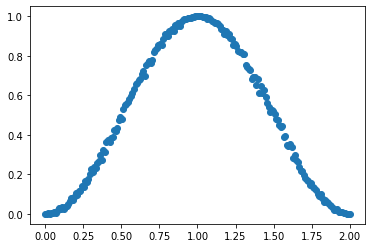

In [8]:
#This is an example of sweeping an exponent of an X Gate

import matplotlib.pyplot as plt
import sympy

# Perform an X gate with variable exponent
q = cirq.GridQubit(1,1)
circuit = cirq.Circuit(cirq.X(q) ** sympy.Symbol('t'),
                       cirq.measure(q, key='m'))

# Sweep exponent from zero (off) to one (on) and back to two (off)
param_sweep = cirq.Linspace('t', start=0, stop=2, length=200)

# Simulate the sweep
s = cirq.Simulator()
trials = s.run_sweep(circuit, param_sweep, repetitions=1000)

# Plot all the results
x_data = [trial.params['t'] for trial in trials]
y_data = [trial.histogram(key='m')[1] / 1000.0 for trial in trials]
plt.scatter('t','p', data={'t': x_data, 'p': y_data})

### Unitary Matrices and Decompositions
Most quantum operations have a unitary matrix representation. This matrix can be accessed by applying cirq.unitary(). This can be applied to gates, operations, circuits that support this protocol and will return the unitary matrix that represents the object.

In [ ]:
print('Unitary of X Gate')
print(cirq.unitary(cirq.X))

print('Unitary of SWAP Operator on Two Qubits')
q0, q1 = cirq.LineQubit.range(2)
print(cirq.unitary(cirq.SWAP(q0, q1)))

print('Unitary of the sample circuit')
print(cirq.unitary(cirq.Circuit(criq.X(q0), cirq.SWAP(q0, q1))))

### Decompositions
Many quantum gates can be decomposed to smaller gates with simpler operations. Cirq.decompose function is primarily used for the decomposition purposes.

In [4]:
##The below example captures the decomposition of Hadamard H gate into X and Y gates:

print(cirq.decompose(cirq.H(cirq.LineQubit(0))))

[(cirq.Y**0.5).on(cirq.LineQubit(0)), cirq.XPowGate(exponent=1.0, global_shift=-0.25).on(cirq.LineQubit(0))]


Another example is the 3-qubit Toffoli gate, which is equivalent to a controlled-controlled-X gate. Many devices do not support a three qubit gate, so it is important

In [5]:
## Decomposition of three qubit toffoli gate to an X gate
q0, q1, q2 = cirq.LineQubit.range(3)
print(cirq.Circuit(cirq.decompose(cirq.TOFFOLI(q0, q1, q2))))


0: ───T────────────────@─────────────────────────────────@─────────────────────────────@────────────────────────────@───────────────────────────────────────
                       │                                 │                             │                            │
1: ───T───────Y^-0.5───@───Y^0.5────@───T^-1────Y^-0.5───@────────Y^0.5───@───Y^-0.5───@──────Y^0.5────@───Y^-0.5───@──────Y^0.5────@───────────────────────
                                    │                                     │                            │                            │
2: ───Y^0.5───X────────T───Y^-0.5───@───Y^0.5───T────────Y^-0.5───────────@───Y^0.5────T^-1───Y^-0.5───@───Y^0.5────T^-1───Y^-0.5───@───Y^0.5───Y^0.5───X───


In [6]:
## Some devices will decompose the gates which are not supported. If we use the Foxtail device from above, we can see this in action by adding an unsupported SWAP gate
swap = cirq.SWAP(cirq.GridQubit(0, 0), cirq.GridQubit(0, 1))
print(cirq.Circuit(swap, device=cirq.google.Foxtail))

(0, 0): ───S^-1───Y^-0.5───@───S^-1───Y^0.5───X^0.5───@───S^-1───X^-0.5───@───S^-1───Z───
                           │                          │                   │
(0, 1): ───Z──────Y^-0.5───@───S^-1───Y^0.5───X^0.5───@───S^-1───X^-0.5───@───S^-1───S───
